# Feature Engineering of Modules Data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.optimize import curve_fit
from scipy.special import gamma
import matplotlib.pyplot as plt

In [2]:
ngs_reads = pd.read_json('exported_datasets/prepared_dataset.json')

After exporting/importing to json, dataformat of columns including dataframes is lost, restore to dfs:

In [3]:
for category in ngs_reads:
    if type(ngs_reads[category][0]) is dict:
        ngs_reads[category] = ngs_reads[category].apply(pd.DataFrame)
        print(category, 'converted to DF')

Per base sequence quality converted to DF
Per tile sequence quality converted to DF
Per sequence quality scores converted to DF
Per base sequence content converted to DF
Per sequence GC content converted to DF
Per base N content converted to DF
Sequence Length Distribution converted to DF
Sequence Duplication Levels converted to DF
Overrepresented sequences converted to DF
Adapter Content converted to DF


#### Show example data

In [4]:
ngs_reads

,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content,...,module_1_status,module_2_status,module_3_status,module_4_status,module_5_status,module_6_status,module_7_status,module_8_status,module_9_status,module_10_status
0,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 3.0 1 ...,Base G A T ...,GC Content Count 0 0 3.00 ...,Base N-Count 0 1 0.479607 1 ...,Length Count 0 30-39 4192.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,0,2,2,0,2,2,1,2,2,2
1,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 13 2.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.009071 1 ...,Length Count 0 30-39 189.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,1,2,0,2,2,1,2,2,2
2,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 1668.0 ...,Base G A T ...,GC Content Count 0 0 1668....,Base N-Count 0 1 0.029292 1 ...,Length Count 0 30-39 4566.0 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,0,1,2,0,1,2,1,1,2,2
3,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 12 2.0 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.0 1 ...,Length Count 0 30-39 8954.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,1,2,2
4,Base Mean Median Lower Quartile...,Tile Base Mean 0 1102 ...,Quality Count 0 15 3.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.0 1 ...,Length Count 0 65-69 1.0 1 70...,Duplication Level Percentage of deduplicat...,...,Position Illumina Universal Adapter Illum...,...,0,0,2,0,0,2,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 15 1.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.080016 1 ...,Length Count 0 35-39 4455.0 1 ...,Duplication Level Percentage of deduplicat...,Se...,Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,0,1,2
180,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 1.0 1 ...,Base G A T ...,GC Content Count 0 0 3...,Base N-Count 0 1 0.000708 1 ...,Length Count 0 35-39 5799.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,0,2,2
181,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 16 2.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.080888 1 ...,Length Count 0 35-39 1949.0 1 ...,Duplication Level Percentage of deduplicat...,Se...,Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,0,1,2
182,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 1.0 1 ...,Base G A T ...,GC Content Count 0 0 0...,Base N-Count 0 1 0.000365 1 ...,Length Count 0 35-39 4278.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,0,2,2


### Module 1- Per base sequence quality

[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/2%20Per%20Base%20Sequence%20Quality.html)
> This view shows an overview of the range of quality values across all bases at each position in the FastQ file.
 For each position a BoxWhisker type plot is drawn. The elements of the plot are as follows:
 > * The central red line is the median value
 > * The yellow box represents the inter-quartile range (25-75%)
 > * The upper and lower whiskers represent the 10% and 90% points
 > * The blue line represents the mean quality

> The y-axis on the graph shows the quality scores. The higher the score the better the base call. The background of the graph divides the y axis into very good quality calls (green), calls of reasonable quality (orange), and calls of poor quality (red). The quality of calls on most platforms will degrade as the run progresses, so it is common to see base calls falling into the orange area towards the end of a read. 
It should be mentioned that there are number of different ways to encode a quality score in a FastQ file. FastQC attempts to automatically determine which encoding method was used, but in some very limited datasets it is possible that it will guess this incorrectly (ironically only when your data is universally very good!). The title of the graph will describe the encoding FastQC thinks your file used. 
Results from this module will not be displayed if your input is a BAM/SAM file in which quality scores have not been recorded. 

![Example Per base sequence quality](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_base_quality.png)  

In [5]:
# Todo: Feature engineering

### Module 2 - Per tile sequence quality

[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/12%20Per%20Tile%20Sequence%20Quality.html)
>  This graph will only appear in your analysis results if you're using an Illumina library which retains its original sequence identifiers. Encoded in these is the flowcell tile from which each read came. The graph allows you to look at the quality scores from each tile across all of your bases to see if there was a loss in quality associated with only one part of the flowcell.  
The plot shows the deviation from the average quality for each tile. The colours are on a cold to hot scale, with cold colours being positions where the quality was at or above the average for that base in the run, and hotter colours indicate that a tile had worse qualities than other tiles for that base. In the example below you can see that certain tiles show consistently poor quality. A good plot should be blue all over.

![Example Per tile sequence quality](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_tile_quality.png)  

#### Extract features for module 2 based on averages grouped by tiles (with weighting)

In [6]:
# the bases for each tile are grouped inconsistently - the first 9 bases are always ungrouped,
# the following bases are grouped in 5, the last bases are grouped until the end (<5)
# example:
ngs_reads['Per tile sequence quality'][0]
# to calculate the correct mean, weights have to be added to enable calculating the weighted average per tile

,Tile,Base,Mean
0,1101,1,0.030195
1,1101,2,-0.063217
2,1101,3,-0.013447
3,1101,4,0.033154
4,1101,5,0.003146
...,...,...,...
2579,2119,280-284,-0.172432
2580,2119,285-289,-1.815671
2581,2119,290-294,0.908856
2582,2119,295-299,0.152131


In [7]:
def add_weights_tiles(row):
    bases = [int(d) for d in str(row['Base']).split('-')]
    if len(bases) == 1:
        return 1
    elif len(bases) == 2:
        return bases[1]-bases[0]+1

In [8]:
def means_per_tile(dataframe):
    module_2 = dataframe['Per tile sequence quality'] #.copy() - if column weight shouldn't be added to original
    module_2["weight"] = module_2.apply(add_weights_tiles, axis=1)
    weighted_avg = module_2.groupby('Tile').apply(lambda x: np.average(x['Mean'], weights=x['weight']))

    std = np.std(weighted_avg)
    sum_negatives = np.sum(weighted_avg[weighted_avg <0])
    #sum_positives = np.sum(weighted_avg[weighted_avg >= 0])
    #mean_negatives = np.mean((weighted_avg[weighted_avg < 0]), axis=0)
    #mean_positives = np.mean((weighted_avg[weighted_avg >= 0]), axis=0)
    #mean = np.mean(weighted_avg)
    return std, sum_negatives, weighted_avg #, sum_positives, mean_negatives, mean_positives, std, mean

    # tested features show very similar behaviour: std and neg/pos mean have the same characteristics
    # sum_positive and sum_negative mirror each other, mean and sum of all always very close to 0 (why?)
    # leaving sum_negatives in for now, any other characteristics?
    # returning completed weighted averages for data exploration

In [9]:
#ngs_reads[['module_2_std', 'module_2_sum_pos', 'module_2_mean_neg', 'module_2_mean_pos', 'module_2_std', 'module_2_mean'
#          ]] = ngs_reads.apply(create_means_df, axis=1, result_type='expand')

In [10]:
ngs_reads[['module_2_std', 'module_2_sum_neg', 'module_2_weighted_avgs'
          ]] = ngs_reads.apply(means_per_tile, axis=1, result_type='expand')

<AxesSubplot:>

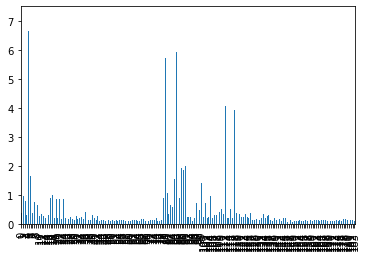

In [11]:
ngs_reads['module_2_std'].plot(kind='bar')

<AxesSubplot:>

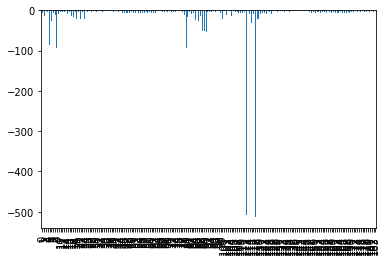

In [12]:
ngs_reads['module_2_sum_neg'].plot(kind='bar')

#### Weighted averages examples

<AxesSubplot:xlabel='Tile'>

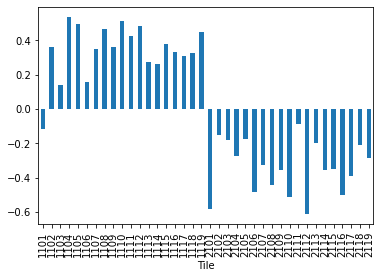

In [13]:
ngs_reads['module_2_weighted_avgs'][0].plot(kind='bar')

<AxesSubplot:xlabel='Tile'>

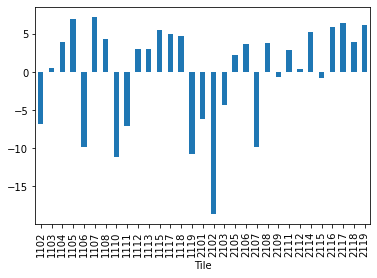

In [14]:
ngs_reads['module_2_weighted_avgs'][4].plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

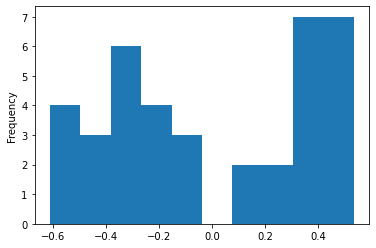

In [15]:
ngs_reads['module_2_weighted_avgs'][0].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

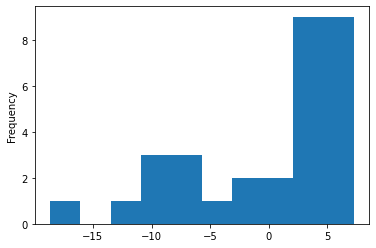

In [16]:
ngs_reads['module_2_weighted_avgs'][4].plot(kind='hist')

In [17]:
ngs_reads.drop(columns='module_2_weighted_avgs', inplace=True) # not a feature
ngs_reads.drop(columns='Per tile sequence quality', inplace=True) # drop original column after feature extraction

### Module 3 - Per sequence quality scores
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/3%20Per%20Sequence%20Quality%20Scores.html)
> The per sequence quality score report allows you to see if a subset of your sequences have universally low quality values. It is often the case that a subset of sequences will have universally poor quality, often because they are poorly imaged (on the edge of the field of view etc), however these should represent only a small percentage of the total sequences.
 If a significant proportion of the sequences in a run have overall low quality then this could indicate some kind of systematic problem - possibly with just part of the run (for example one end of a flowcell).

![Example Per sequence quality scores](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_sequence_quality.png)  

In [18]:
# Todo: Feature engineering

### Module 4 - Per base sequence content
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/4%20Per%20Base%20Sequence%20Content.html)
> Per Base Sequence Content plots out the proportion of each base position in a file for which each of the four normal DNA bases has been called. 
 In a random library you would expect that there would be little to no difference between the different bases of a sequence run, so the lines in this plot should run parallel with each other. The relative amount of each base should reflect the overall amount of these bases in your genome, but in any case they should not be hugely imbalanced from each other.
 It's worth noting that some types of library will always produce biased sequence composition, normally at the start of the read. Libraries produced by priming using random hexamers (including nearly all RNA-Seq libraries) and those which were fragmented using transposases inherit an intrinsic bias in the positions at which reads start. This bias does not concern an absolute sequence, but instead provides enrichement of a number of different K-mers at the 5' end of the reads. Whilst this is a true technical bias, it isn't something which can be corrected by trimming and in most cases doesn't seem to adversely affect the downstream analysis. It will however produce a warning or error in this module. 
 
![Example Per base sequence content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_base_sequence_content.png)  

In [19]:
# Todo: Feature engineering

### Module 5 - Per sequence GC content
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/5%20Per%20Sequence%20GC%20Content.html)
> This module measures the GC content across the whole length of each sequence in a file and compares it to a modelled normal distribution of GC content.  
In a normal random library you would expect to see a roughly normal distribution of GC content where the central peak corresponds to the overall GC content of the underlying genome. Since we don't know the the GC content of the genome the modal GC content is calculated from the observed data and used to build a reference distribution.
An unusually shaped distribution could indicate a contaminated library or some other kinds of biased subset. A normal distribution which is shifted indicates some systematic bias which is independent of base position. If there is a systematic bias which creates a shifted normal distribution then this won't be flagged as an error by the module since it doesn't know what your genome's GC content should be. 

![Example Per sequence GC content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_sequence_gc_content.png)  

Due to similarity to Module 4 this module will be ignored for feature extraction.

In [20]:
ngs_reads.drop(columns='Per sequence GC content', inplace=True)

### Module 6 - Per base N content
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/6%20Per%20Base%20N%20Content.html)
>  If a sequencer is unable to make a base call with sufficient confidence then it will normally substitute an N rather than a conventional base call. 
This module plots out the percentage of base calls at each position for which an N was called. 
It's not unusual to see a very low proportion of Ns appearing in a sequence, especially nearer the end of a sequence. However, if this proportion rises above a few percent it suggests that the analysis pipeline was unable to interpret the data well enough to make valid base calls. 

![Example Per base N content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_base_n_content.png)  

In [21]:
ngs_reads['Per base N content'][0] # is N-count summed or averaged for grou

,Base,N-Count
0,1,0.479607
1,2,0.027948
2,3,0.015831
3,4,0.008795
4,5,0.008208
...,...,...
63,280-284,0.075072
64,285-289,0.060851
65,290-294,0.000000
66,295-299,0.322535


<AxesSubplot:>

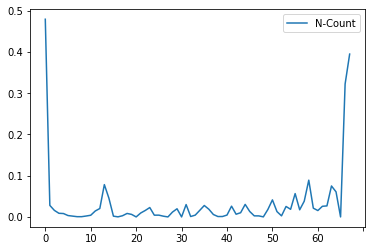

In [22]:
ngs_reads['Per base N content'][0].plot()

<AxesSubplot:>

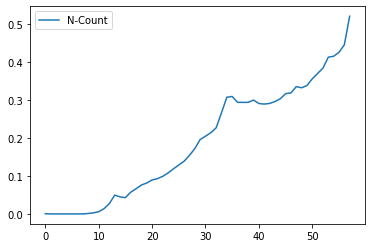

In [23]:
ngs_reads['Per base N content'][71].plot()

In [24]:
def sum_ncount(row):
    return row['Per base N content']['N-Count'].sum()

In [25]:
ngs_reads['module_6_ncount'] = ngs_reads.apply(sum_ncount, axis=1)

<AxesSubplot:>

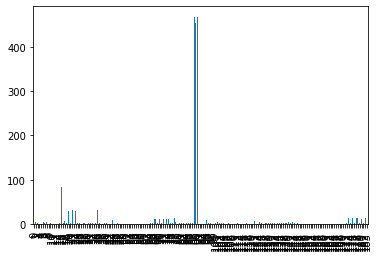

In [26]:
ngs_reads['module_6_ncount'].plot(kind='bar')

<AxesSubplot:>

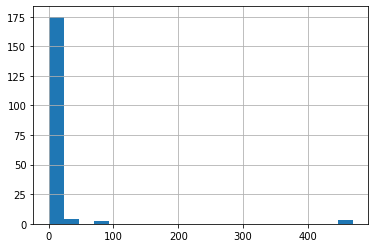

In [27]:
ngs_reads['module_6_ncount'].hist(bins=20)

In [28]:
#drop original column after feature extraction
ngs_reads.drop(columns='Per base N content', inplace=True)

### Module 7 - Sequence length distribution
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/7%20Sequence%20Length%20Distribution.html)
>   Some high throughput sequencers generate sequence fragments of uniform length, but others can contain reads of wildly varying lengths. Even within uniform length libraries some pipelines will trim sequences to remove poor quality base calls from the end. 
This module generates a graph showing the distribution of fragment sizes in the file which was analysed. 
 In many cases this will produce a simple graph showing a peak only at one size, but for variable length FastQ files this will show the relative amounts of each different size of sequence fragment. 
 
![Example Sequence length distribution](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/sequence_length_distribution.png)  

#### Examples:

<AxesSubplot:>

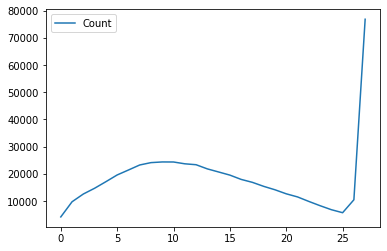

In [29]:
ngs_reads['Sequence Length Distribution'][0].plot()

<AxesSubplot:>

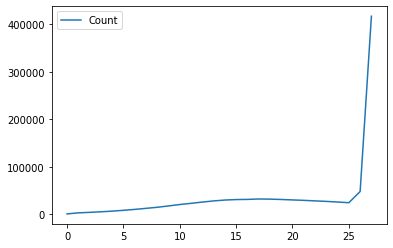

In [30]:
ngs_reads['Sequence Length Distribution'][42].plot()

In [31]:
ngs_reads['Sequence Length Distribution'][0]

,Length,Count
0,30-39,4192.0
1,40-49,9763.0
2,50-59,12611.0
3,60-69,14726.0
4,70-79,17135.0
5,80-89,19612.0
6,90-99,21429.0
7,100-109,23278.0
8,110-119,24146.0
9,120-129,24394.0


In [32]:
#some distributions with only one value:
ngs_reads['Sequence Length Distribution'][125]

,Length,Count
0,251,1681956.0


/home/alex/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


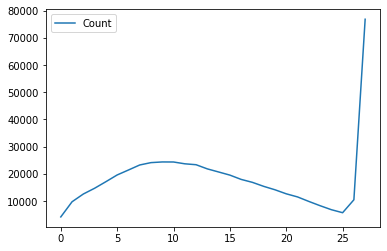

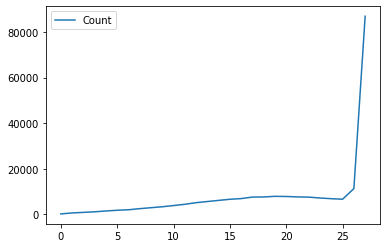

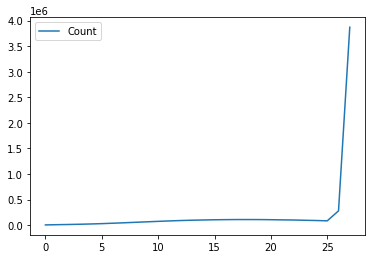

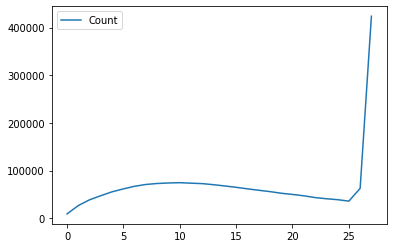

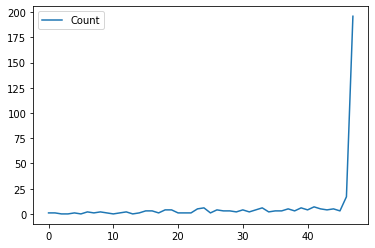

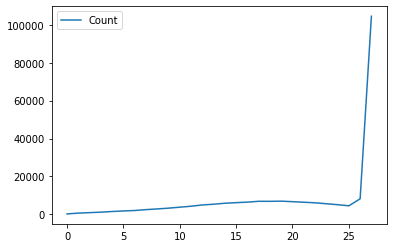

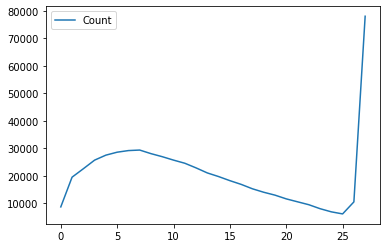

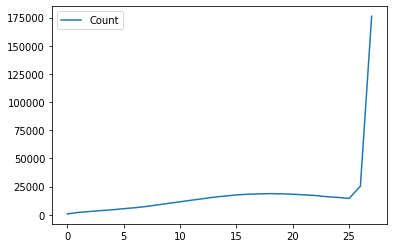

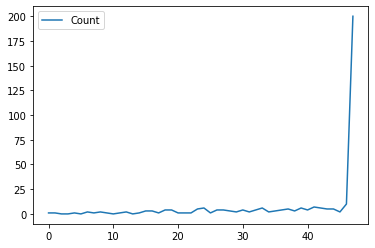

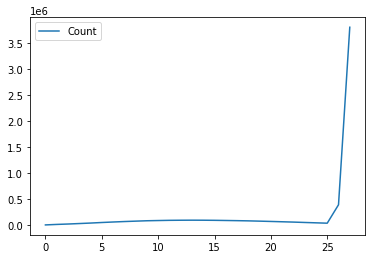

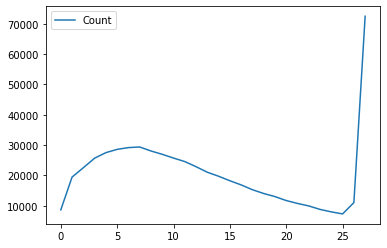

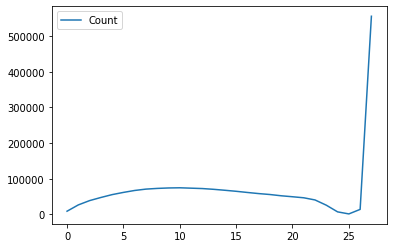

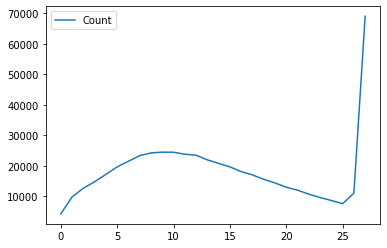

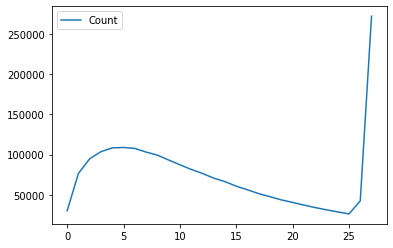

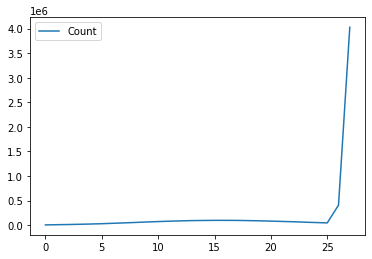

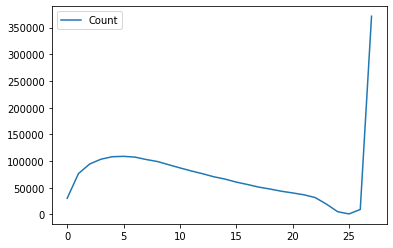

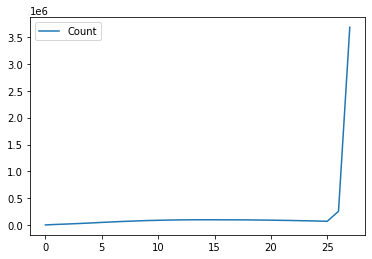

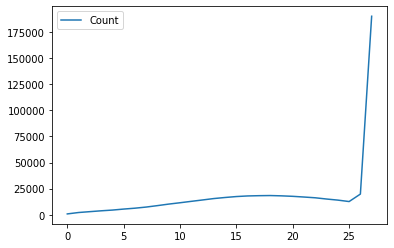

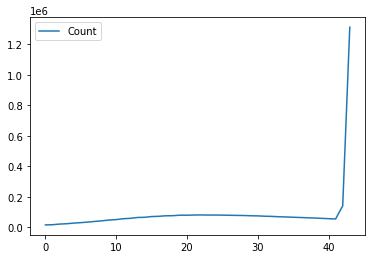

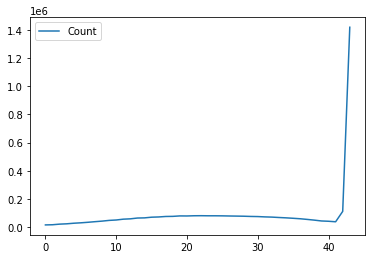

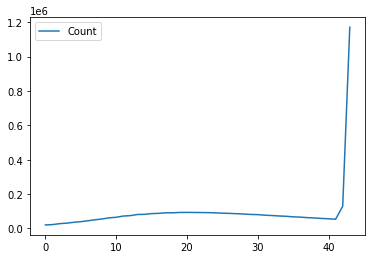

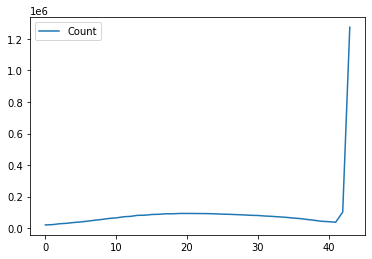

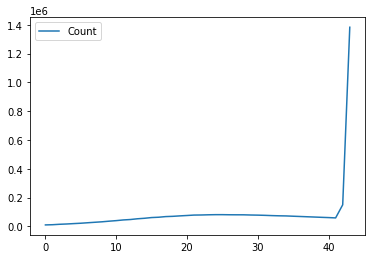

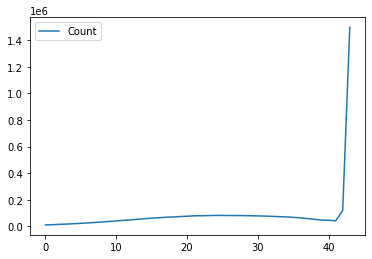

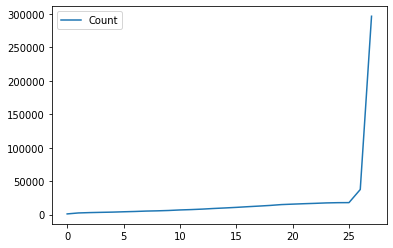

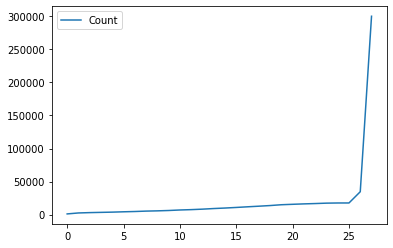

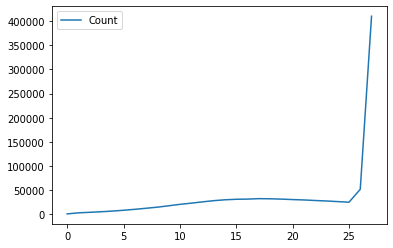

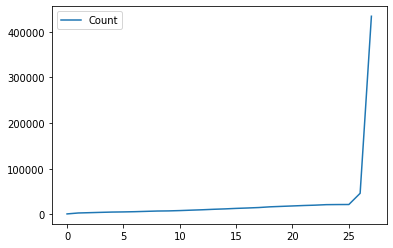

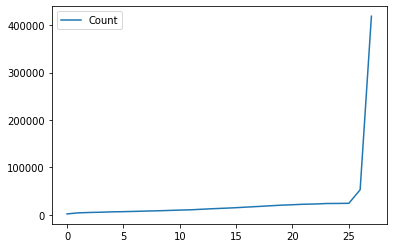

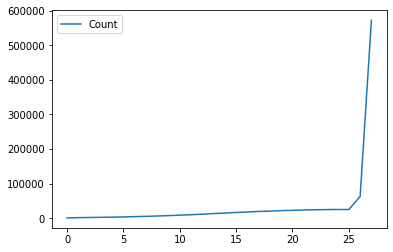

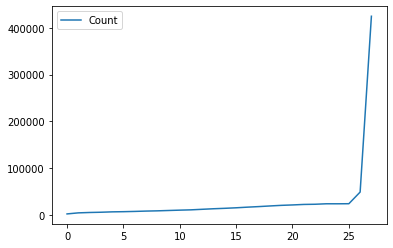

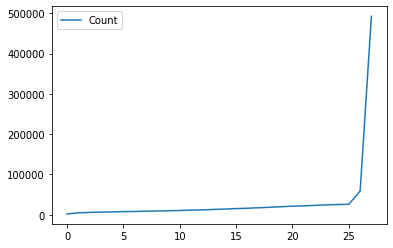

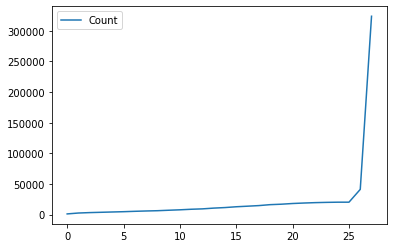

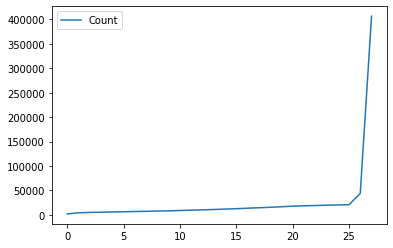

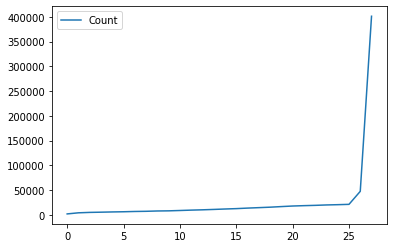

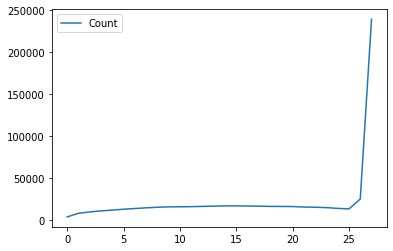

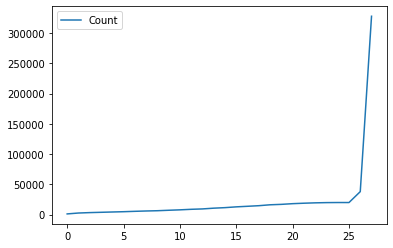

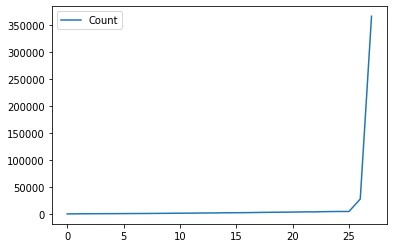

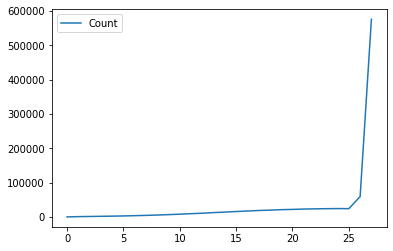

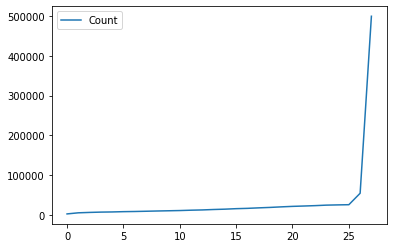

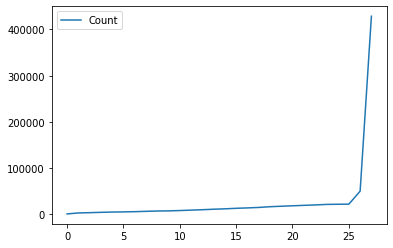

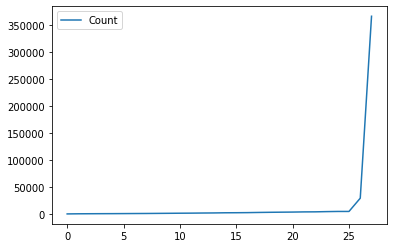

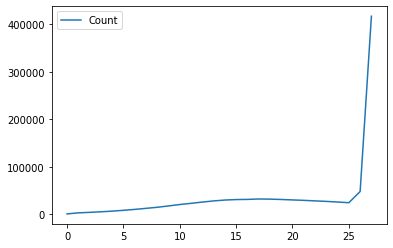

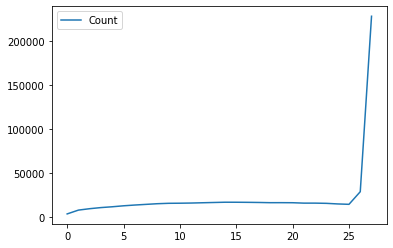

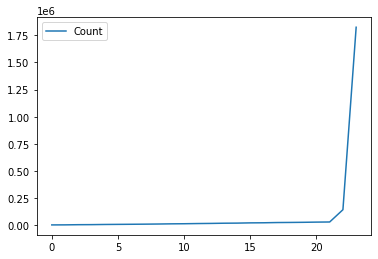

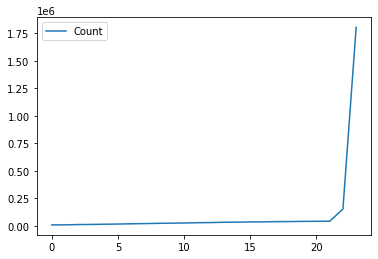

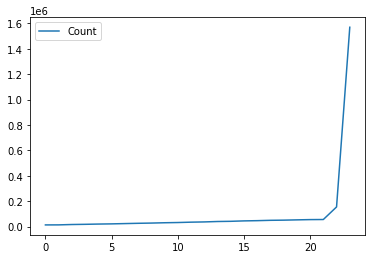

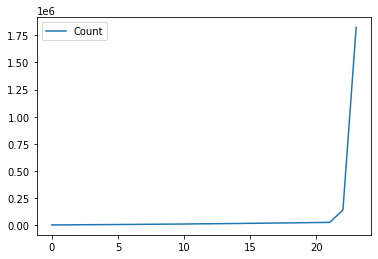

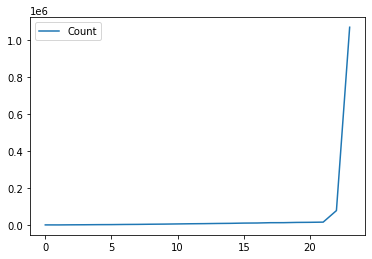

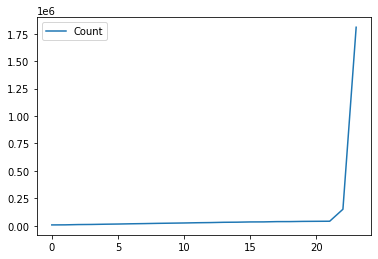

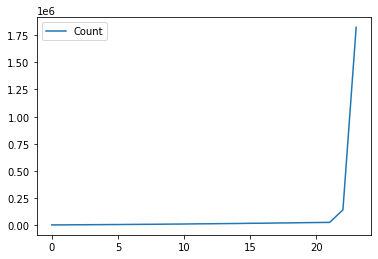

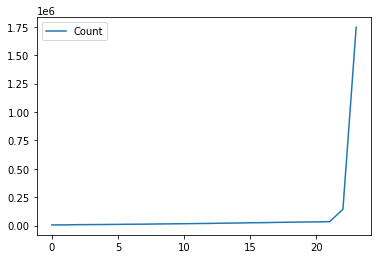

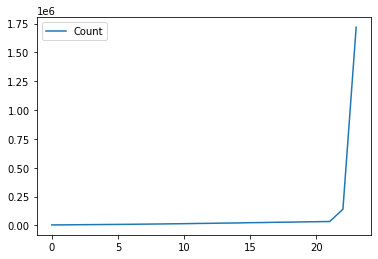

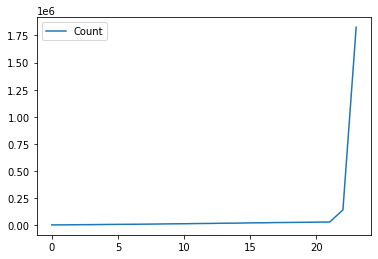

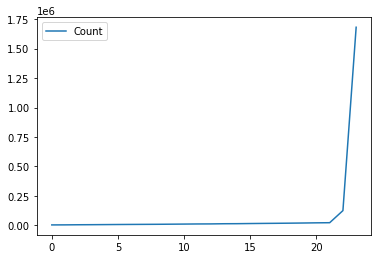

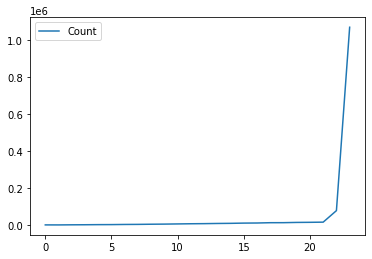

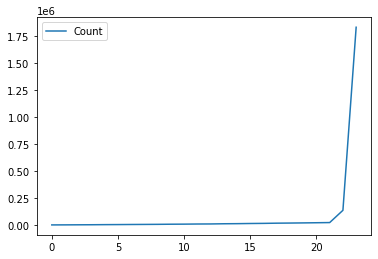

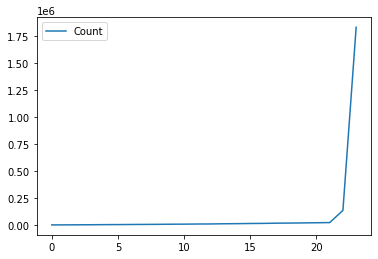

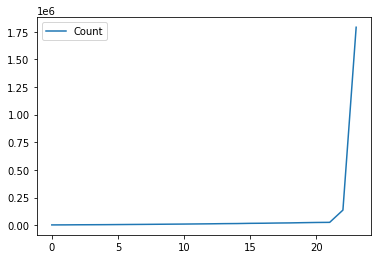

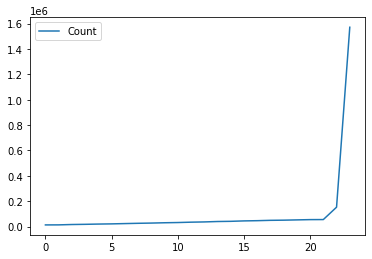

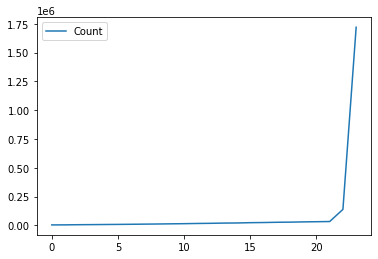

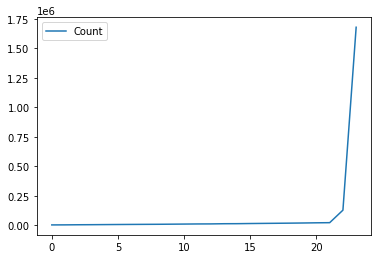

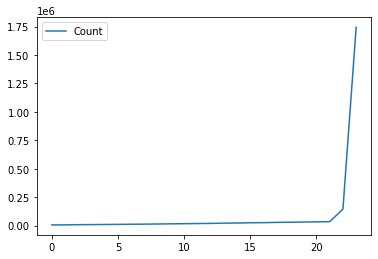

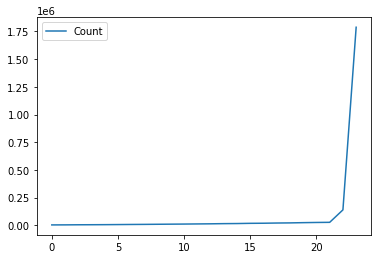

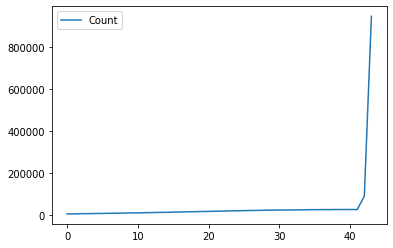

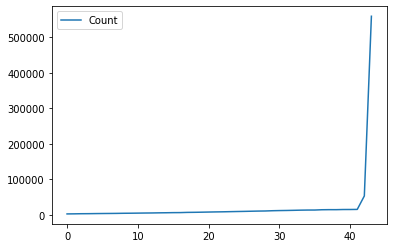

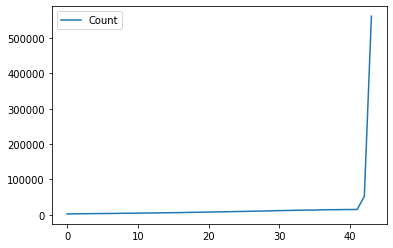

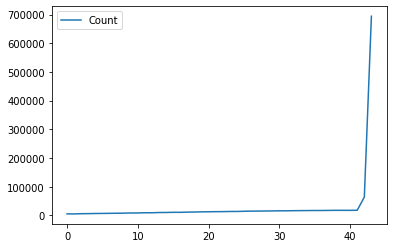

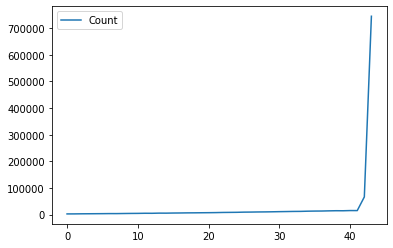

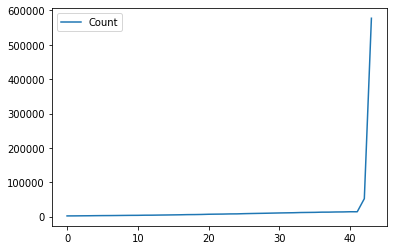

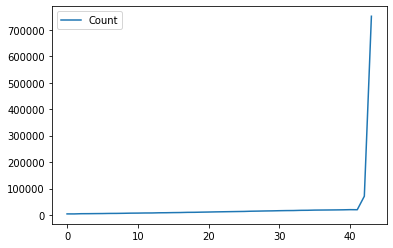

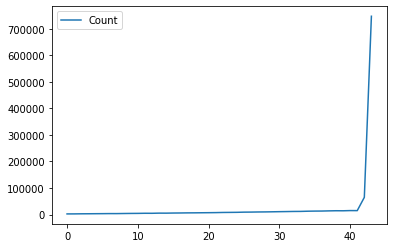

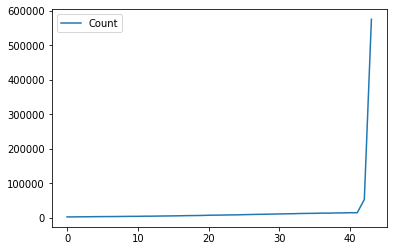

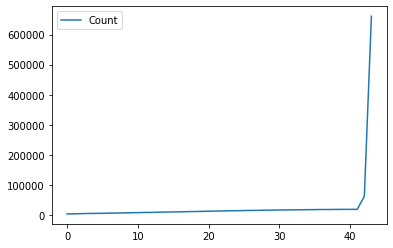

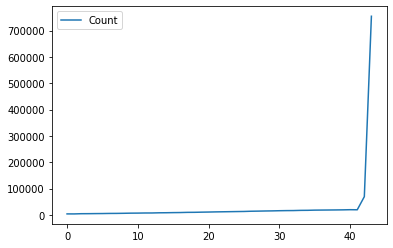

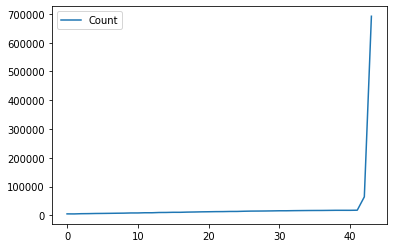

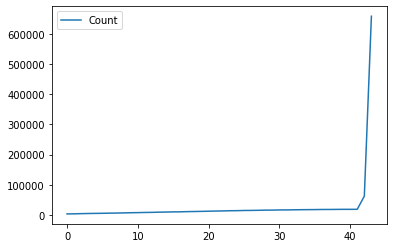

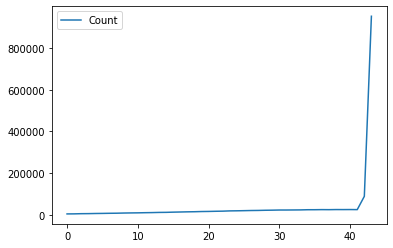

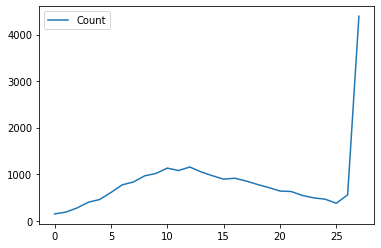

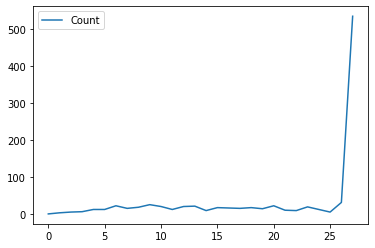

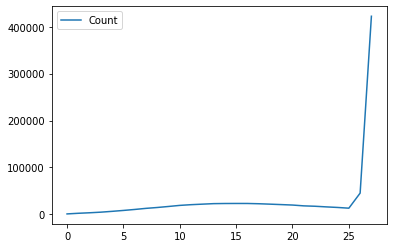

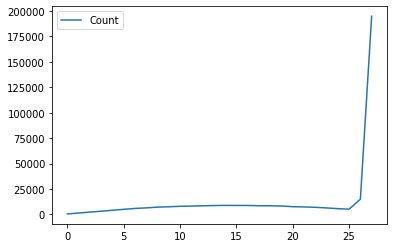

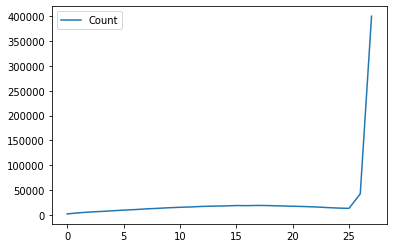

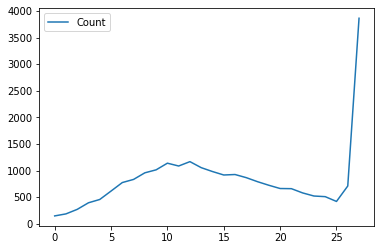

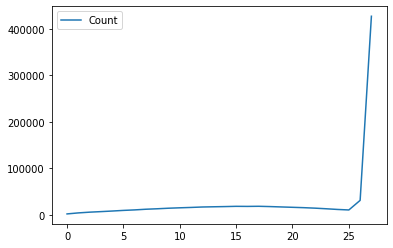

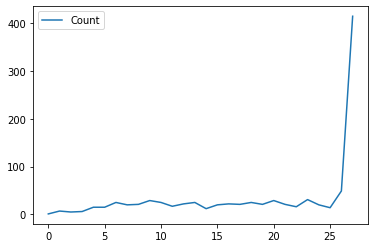

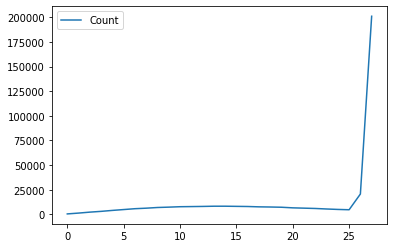

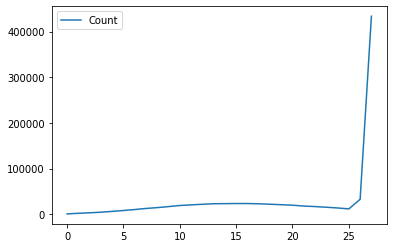

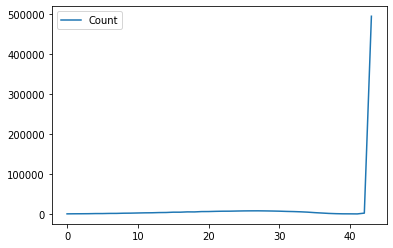

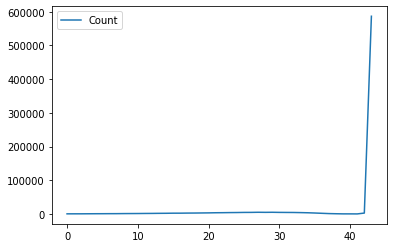

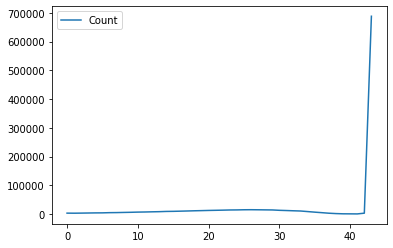

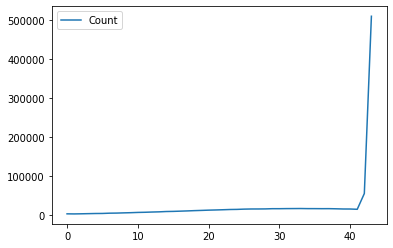

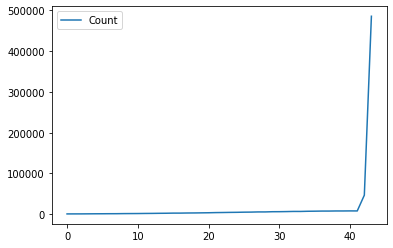

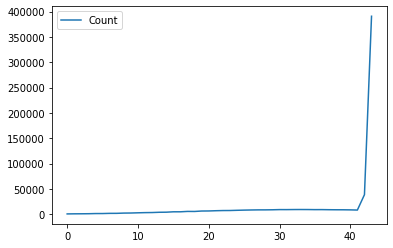

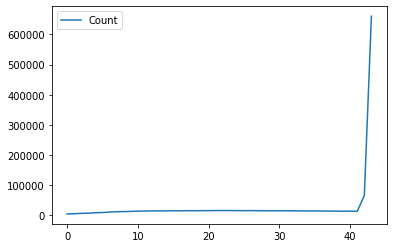

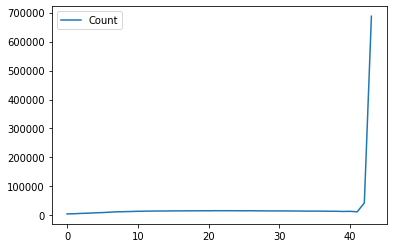

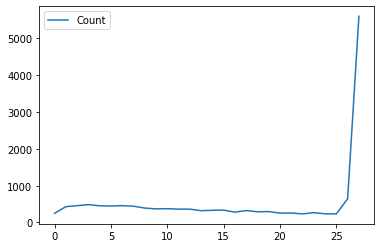

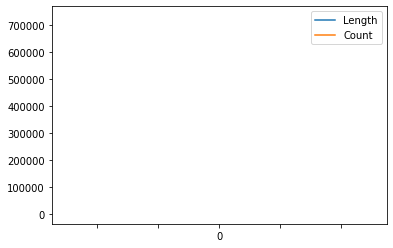

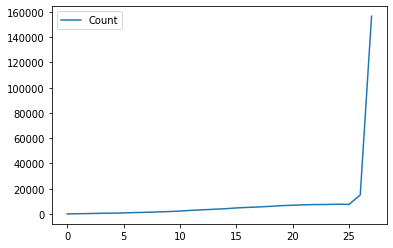

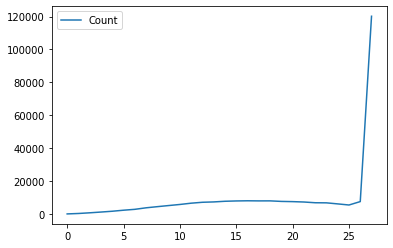

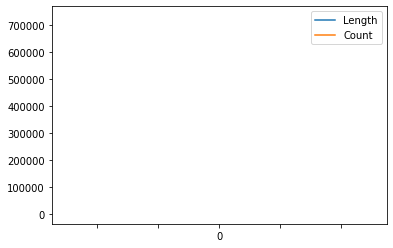

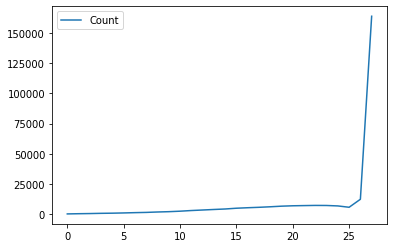

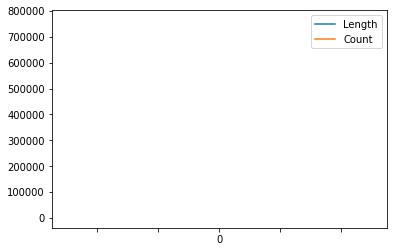

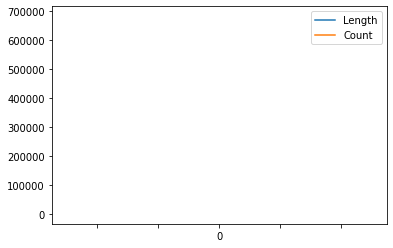

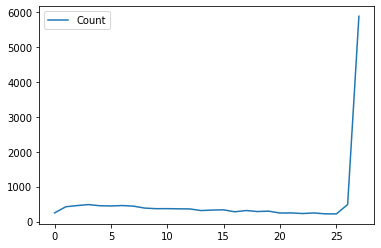

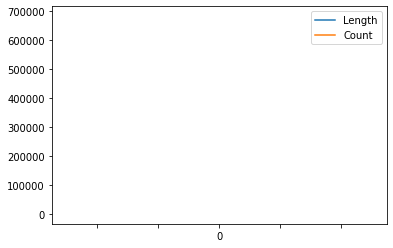

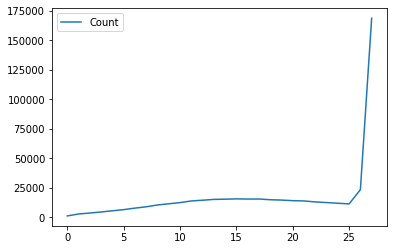

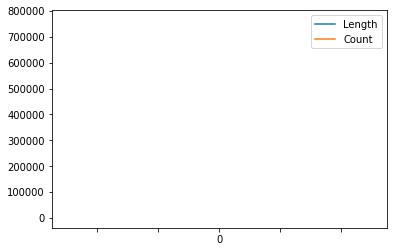

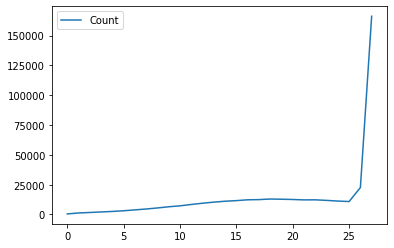

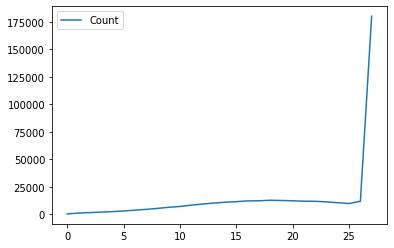

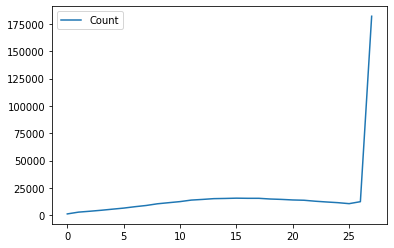

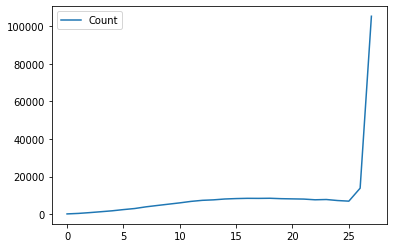

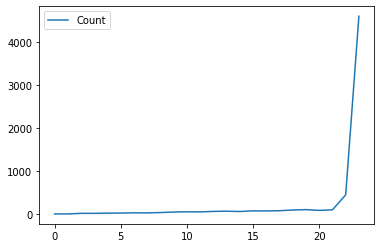

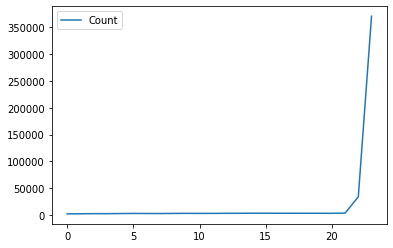

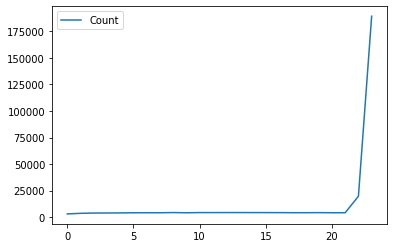

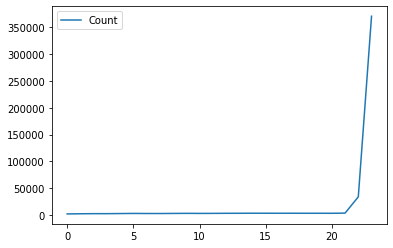

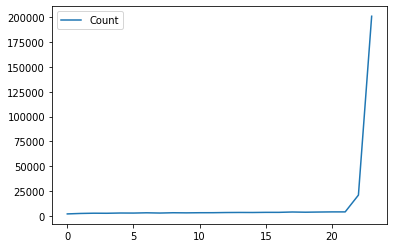

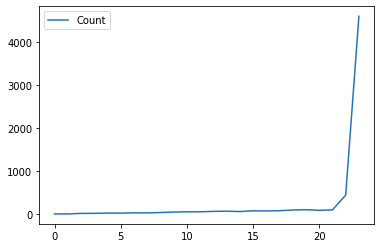

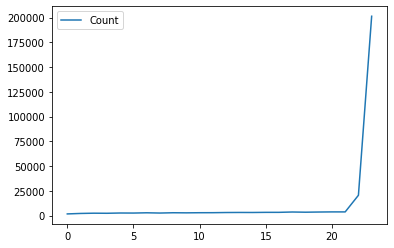

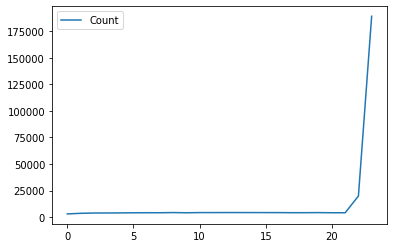

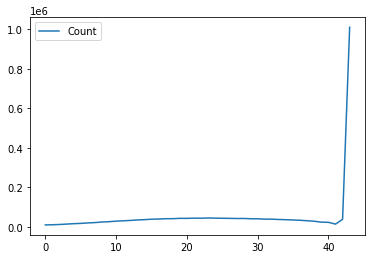

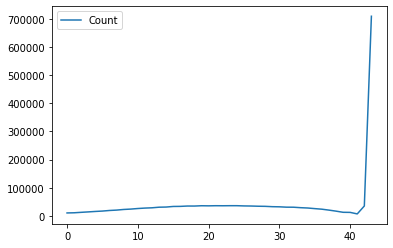

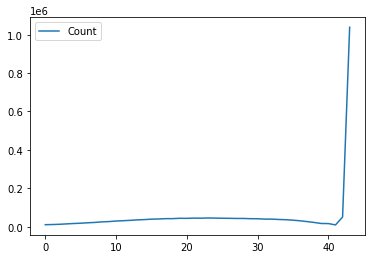

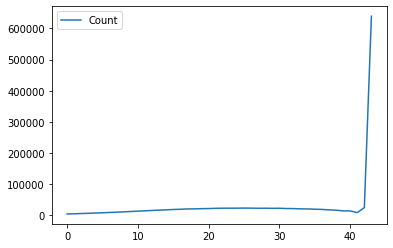

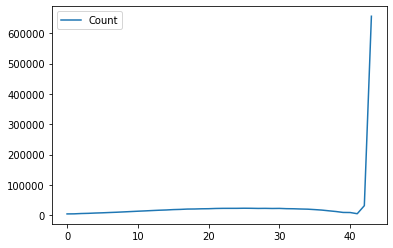

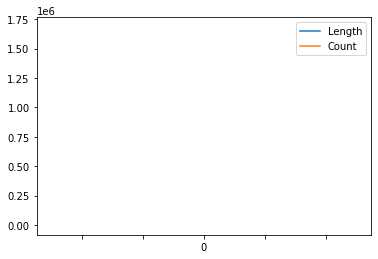

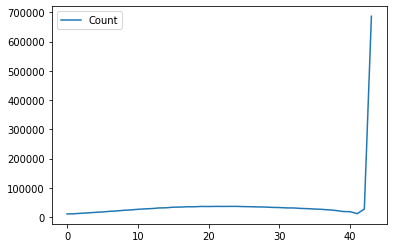

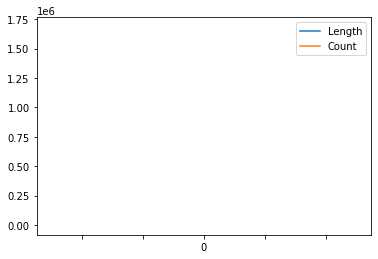

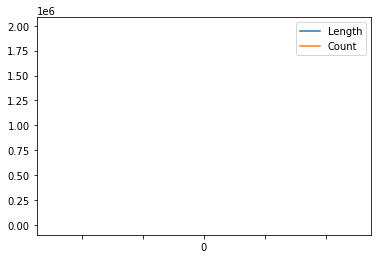

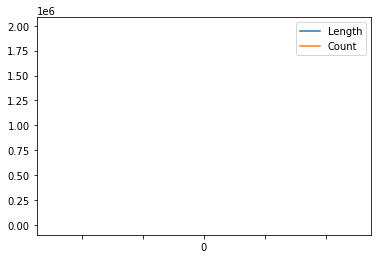

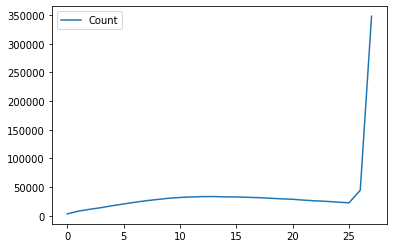

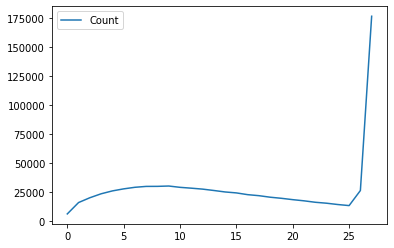

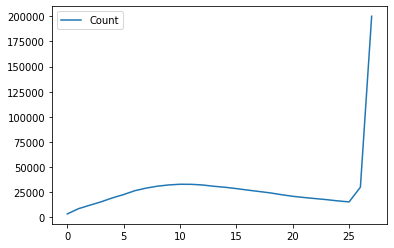

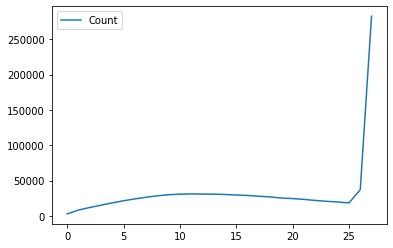

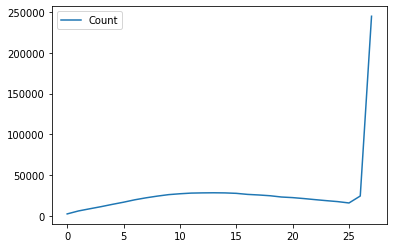

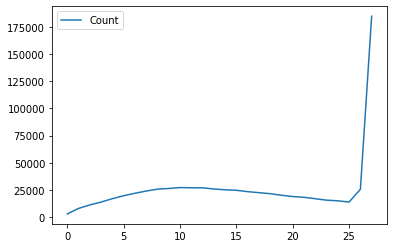

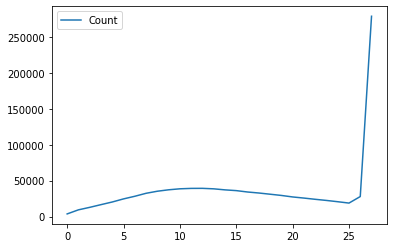

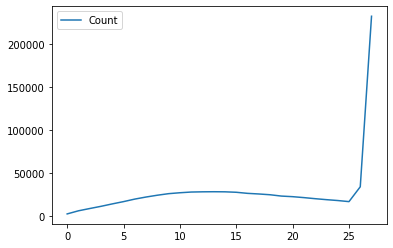

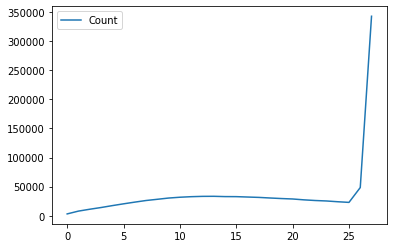

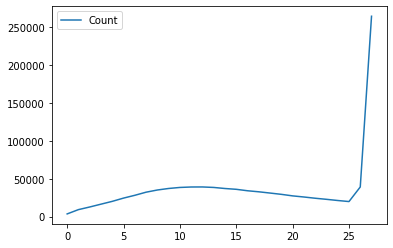

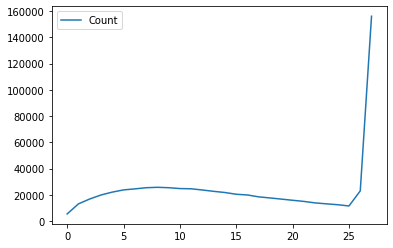

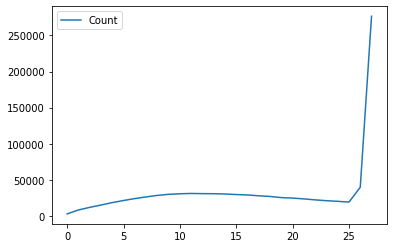

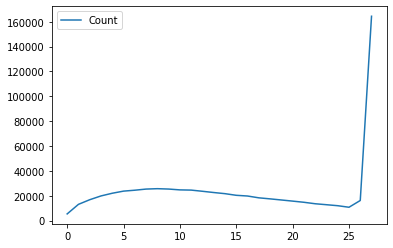

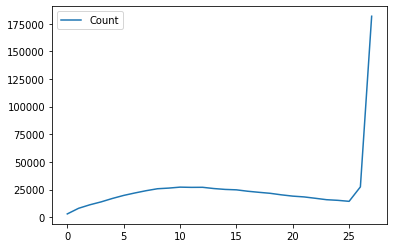

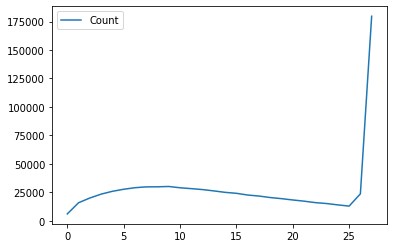

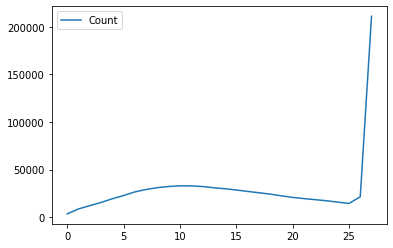

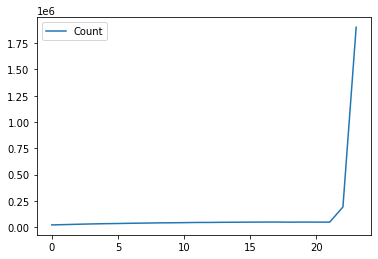

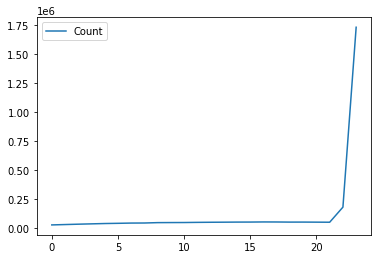

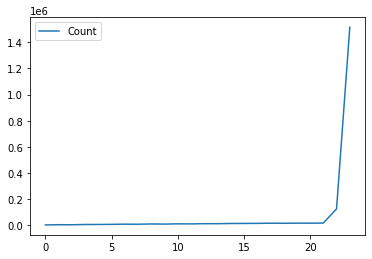

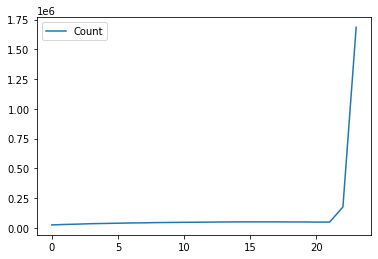

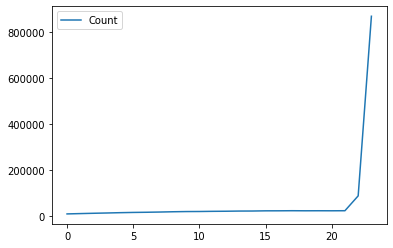

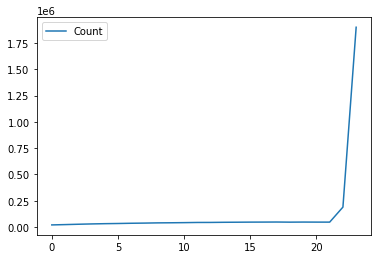

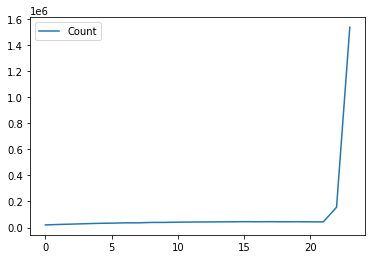

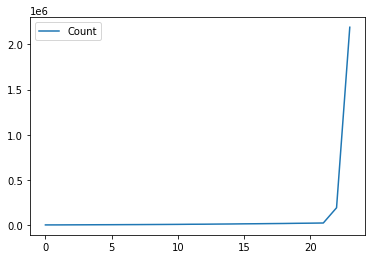

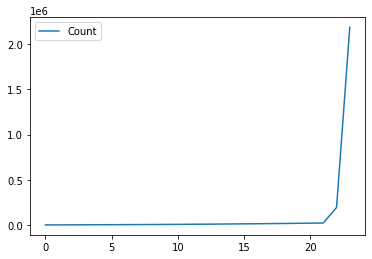

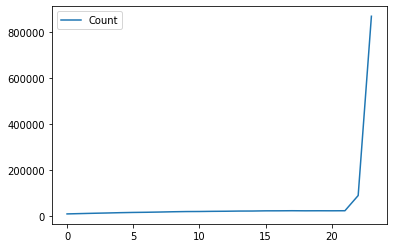

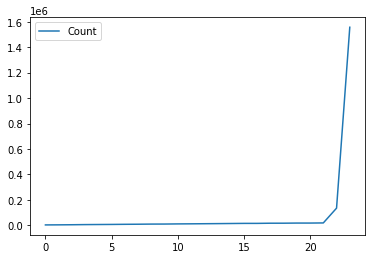

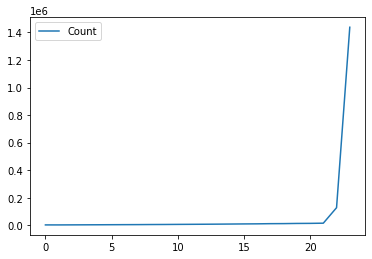

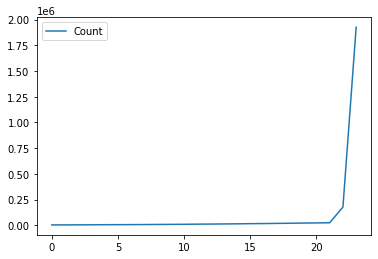

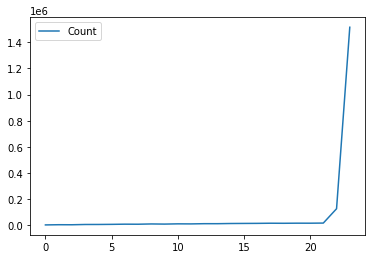

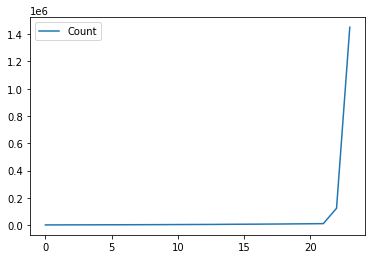

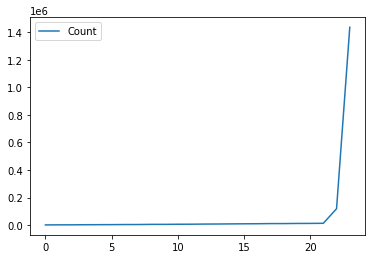

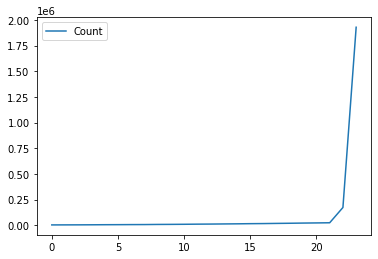

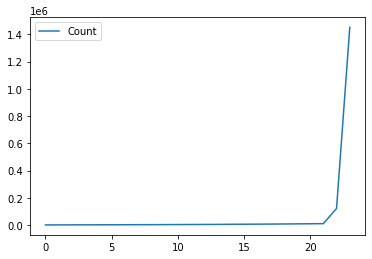

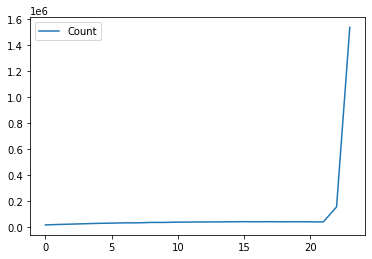

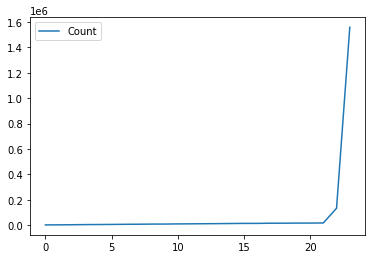

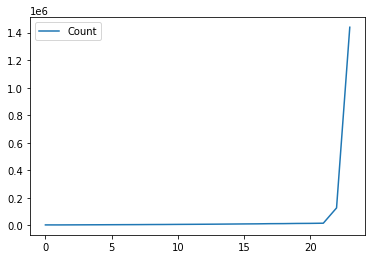

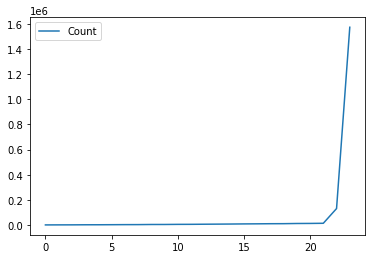

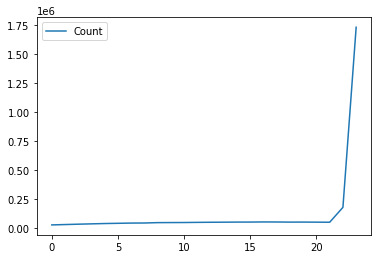

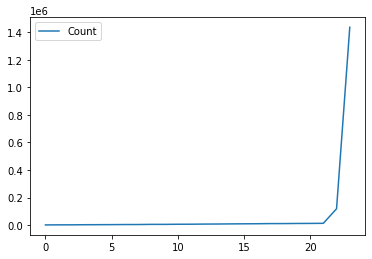

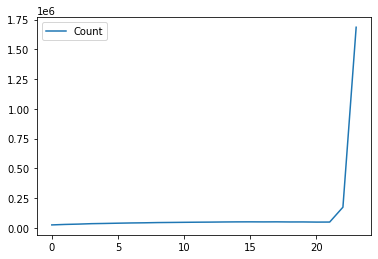

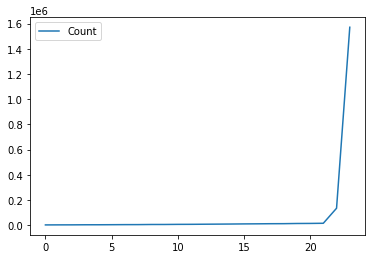

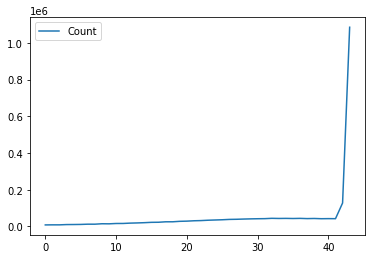

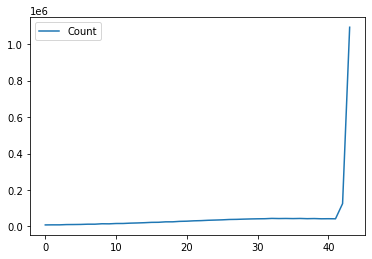

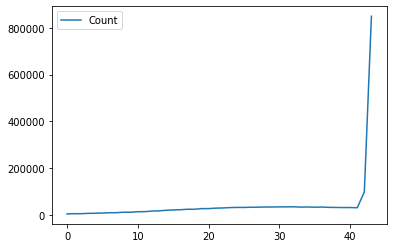

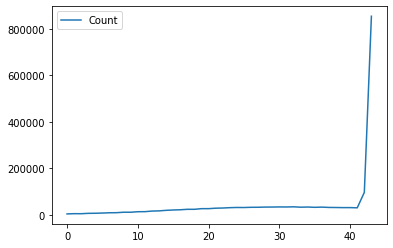

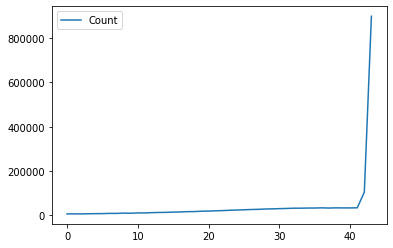

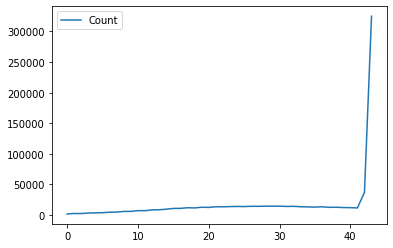

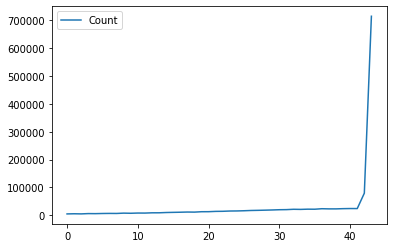

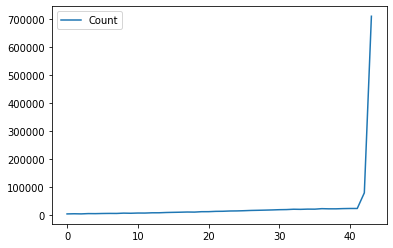

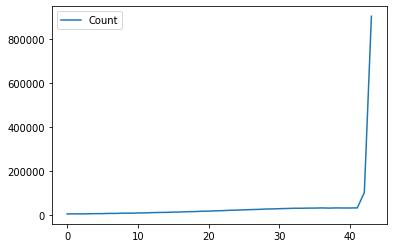

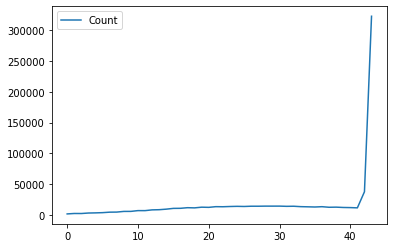

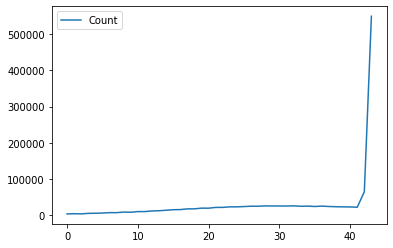

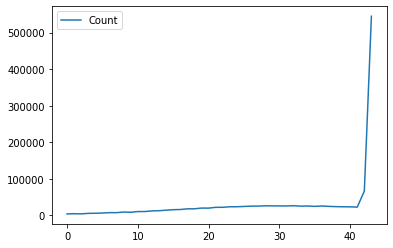

In [33]:
# all plots
for index, row in ngs_reads.iterrows():
    row['Sequence Length Distribution'].plot(kind="line")

#### Apply fitting to complete dataset

##### Option A: using curve_fit, utilizes own beta_fit function to model the distribution of the data

Advantages:
* no "flattening" (what is the correct term?) of distribution table necessary, can be used as is
* no hardcoding of a and b for any tables necessary
* possible add a gaussian function to the fitting to capture distributions of some tables better (e.g. 0, 6), but would lead to more features

Issues: 
* all a values are between 169 and 171, could make sense to subtract 169 from all results to use as ML Feature but of course the distribution curves would look completely wrong then
* curve_fit can't find a fit for tables with only one row (e.g. 97, 125): workaround with imputing


In [37]:
def beta_fit(x, a, b):
        y = (gamma(a+b)*x**(a-1)*(1-x)**(b-1))/(gamma(a)*gamma(b))
        return y

def sequence_length_distribution_curvefit(row):

    table = row['Sequence Length Distribution'].copy()
    
    #impute values for tables with only one value (changes original table in dataset)
    if len(table) < 2:
        table.loc[1] = [table['Length'][0]-1, 0.0]
        table.loc[2] = table.iloc[0]
        table.iloc[0] = [39, 0.0]
        table.reset_index(drop=True, inplace=True) # not necessary, just to be safe

    x = table['Length'].astype(str).str.split("-").str[-1].astype(float).astype(int)
    x = x/(x.iloc[-1]+1) #+1 because highest x_value has to be lower than 1 

    y = table['Count']


    a_b, covariance = curve_fit(beta_fit, x, y, maxfev=10000) 
    
    return a_b[0], a_b[1]

##### Option B: using beta.fit

Advantages:
* data imputation for tables with 1 row not needed

Issues:
* beta.fit needs "flattened" data, not the distribution data
* extreme a, b results for tables with one row (e^36+), some don't converge at all (eg. 79) - workaround: hardcoding a, b values for those with high values (for all other tables a is between 1 and 18 and b betweend 0 and 1 so 25 and 1.5 would already be high enough to distinguish from the rest)
* slower

In [61]:
def sequence_length_distribution_betafit(row):
    table = row['Sequence Length Distribution']
    
    x = table['Length'].astype(str).str.split("-").str[-1].astype(float).astype(int)
    x = x/(x.iloc[-1]+1) #+1 because highest x_value has to be lower than scale, alternative: fscale=0.0001 or x/max(x)+1
    y = table['Count']

    dataset=[]
    for i in range(len(x)):
        for j in range(int(y[i])):
            dataset.append(x[i])

    data_a = np.array(dataset)

    #table with only one length result in huge a,b values (e^36+), some don't converge at all (eg. 79)
    #workaround assigns them large values without fitting
    if len(table)==1:
        a = b = 25 #all fitted distributions are between 1 and 18 for a and
        b = 1.5 # 0 and 1 for b, fixed values maybe not ideal and should be adjusted for different datasets
    else: 
        a, b, loc, scale  = beta.fit(data_a, floc=0, fscale=1)

    return a, b

For now, adding both methods to the dataset and check for differences in the classification

In [39]:
ngs_reads[['module_7_alpha_curvefit', 'module_7_beta_curvefit'
          ]] = ngs_reads.apply(sequence_length_distribution_curvefit, axis=1, result_type='expand')

/home/alex/.local/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [40]:
ngs_reads[['module_7_alpha_betafit', 'module_7_beta_betafit'
          ]] = ngs_reads.apply(sequence_length_distribution_betafit, axis=1, result_type='expand')

#### Example Visualizations

Option A using beta.fit

7.8495123864016 0.4169862180853716


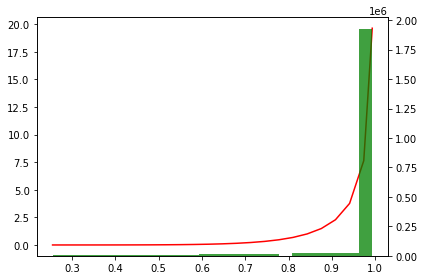

In [34]:
# fit with beta.fit by "flattening" the original table
table = ngs_reads['Sequence Length Distribution'][58] #97, 125
#table = table[table.Count>0.0]


x = table['Length'].astype(str).str.split("-").str[-1].astype(float).astype(int)
x = x/(x.iloc[-1]+1) #+1 because highest x_value has to be lower than scale, alternative: fscale=0.0001 or x/max(x)+1
y = table['Count']

dataset=[]
for i in range(len(x)):
    for j in range(int(y[i])):
        dataset.append(x[i])

data_a = np.array(dataset)

if len(table)==1:
    a = b = 5
else: 
    a, b, loc, scale  = beta.fit(data_a, floc=0, fscale=1)
    
print(a, b)

pdf = beta.pdf(x, a, b)

fig, ax1 = plt.subplots()
ax1.plot(x, pdf, "r-")#, x, y2, "r--", x, y3, "g--")
ax2 = ax1.twinx()
ax2.hist(data_a, alpha=0.75, color='green', bins=len(table))
fig.tight_layout()
plt.show()

Option B using curve_fit

[169.96763351   1.6139185 ]


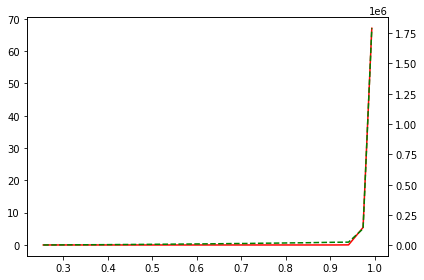

In [36]:
# alternative so the distribution table can be used directly 
# alpha values always very high compared to beta.fit

table = ngs_reads['Sequence Length Distribution'][58].copy() 

if len(table) < 2: # eg. 97, 125
    table.loc[1] = [table['Length'][0]-1, 0.0]
    table.loc[2] = table.iloc[0]
    table.iloc[0] = [39, 0.0]
    table.reset_index(drop=True, inplace=True)
    
x = table['Length'].astype(str).str.split("-").str[-1].astype(float).astype(int)
x = x/(x.iloc[-1]+1) #+1 because highest x_value has to be lower than scale, alternative: fscale=0.0001 or x/max(x)+1

y = table['Count']


a_b, covariance = curve_fit(beta_fit, x, y, maxfev=10000) #, p0=[1.9684620603925647, 0.332246101706947])
print(a_b)

fig, ax1 = plt.subplots()
ax1.plot(x, beta_fit(x, *a_b), "r-")#, x, y2, "r--", x, y3, "g--")
ax2 = ax1.twinx()
ax2.plot(x, y, "g--")
fig.tight_layout()
plt.show()

#### Resulting Features

<AxesSubplot:>

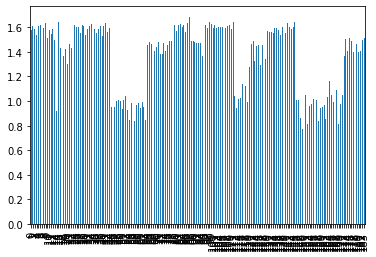

In [58]:
(ngs_reads['module_7_alpha_curvefit']-169).plot(kind='bar')

<AxesSubplot:>

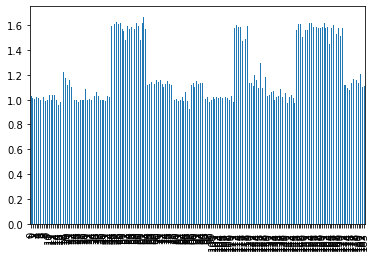

In [42]:
ngs_reads['module_7_beta_curvefit'].plot(kind='bar')

<AxesSubplot:>

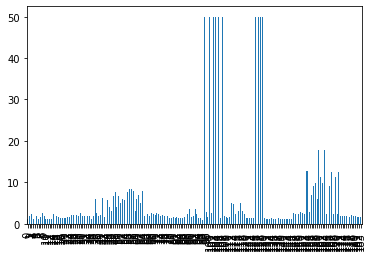

In [59]:
ngs_reads['module_7_alpha_betafit'].plot(kind='bar')

<AxesSubplot:>

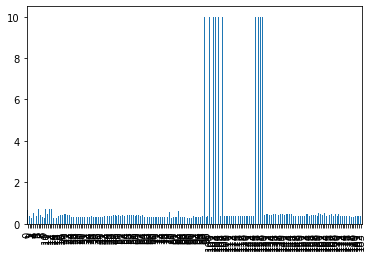

In [60]:
ngs_reads['module_7_beta_betafit'].plot(kind='bar')

In [45]:
#drop original column after feature extraction
ngs_reads.drop(columns='Sequence Length Distribution', inplace=True)

### Module 8 - Sequence duplication levels
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/8%20Duplicate%20Sequences.html)
> In a diverse library most sequences will occur only once in the final set. A low level of duplication may indicate a very high level of coverage of the target sequence, but a high level of duplication is more likely to indicate some kind of enrichment bias (eg PCR over amplification).  
 To cut down on the memory requirements for this module only sequences which first appear in the first 100,000 sequences in each file are analysed, but this should be enough to get a good impression for the duplication levels in the whole file. Each sequence is tracked to the end of the file to give a representative count of the overall duplication level.  
 To cut down on the amount of information in the final plot any sequences with more than 10 duplicates are placed into grouped bins to give a clear impression of the overall duplication level without having to show each individual duplication value.  
 Because the duplication detection requires an exact sequence match over the whole length of the sequence, any reads over 75bp in length are truncated to 50bp for the purposes of this analysis. Even so, longer reads are more likely to contain sequencing errors which will artificially increase the observed diversity and will tend to underrepresent highly duplicated sequences.  
The plot shows the proportion of the library which is made up of sequences in each of the different duplication level bins. There are two lines on the plot. The blue line takes the full sequence set and shows how its duplication levels are distributed. In the red plot the sequences are de-duplicated and the proportions shown are the proportions of the deduplicated set which come from different duplication levels in the original data.  
In a properly diverse library most sequences should fall into the far left of the plot in both the red and blue lines. A general level of enrichment, indicating broad oversequencing in the library will tend to flatten the lines, lowering the low end and generally raising other categories. More specific enrichments of subsets, or the presence of low complexity contaminants will tend to produce spikes towards the right of the plot. These high duplication peaks will most often appear in the blue trace as they make up a high proportion of the original library, but usually disappear in the red trace as they make up an insignificant proportion of the deduplicated set. If peaks persist in the blue trace then this suggests that there are a large number of different highly duplicated sequences which might indicate either a contaminant set or a very severe technical duplication.  
The module also calculates an expected overall loss of sequence were the library to be deduplicated. This headline figure is shown at the top of the plot and gives a reasonable impression of the potential overall level of loss. 
 
![Example Sequence duplication levels](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/duplication_levels.png)  

In [46]:
# Todo: Feature engineering

### Module 9 - Overrepresented sequences
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/9%20Overrepresented%20Sequences.html)
>  A normal high-throughput library will contain a diverse set of sequences, with no individual sequence making up a tiny fraction of the whole. Finding that a single sequence is very overrepresented in the set either means that it is highly biologically significant, or indicates that the library is contaminated, or not as diverse as you expected.  
This module lists all of the sequence which make up more than 0.1% of the total. To conserve memory only sequences which appear in the first 100,000 sequences are tracked to the end of the file. It is therefore possible that a sequence which is overrepresented but doesn't appear at the start of the file for some reason could be missed by this module.  
For each overrepresented sequence the program will look for matches in a database of common contaminants and will report the best hit it finds. Hits must be at least 20bp in length and have no more than 1 mismatch. Finding a hit doesn't necessarily mean that this is the source of the contamination, but may point you in the right direction. It's also worth pointing out that many adapter sequences are very similar to each other so you may get a hit reported which isn't technically correct, but which has very similar sequence to the actual match.  
Because the duplication detection requires an exact sequence match over the whole length of the sequence any reads over 75bp in length are truncated to 50bp for the purposes of this analysis. Even so, longer reads are more likely to contain sequencing errors which will artificially increase the observed diversity and will tend to underrepresent highly duplicated sequences.   

In [47]:
ngs_reads['Overrepresented sequences'][4]

,Sequence,Count,Percentage,Possible Source
0,GTTTTAAAAGTGTCAAAATTGAATGCAATTATCATGCATATGATTA...,1,0.299401,No Hit
1,GTATTAATAAATCCATAACCGCATGTTCTGCCACACTAACTGTATT...,1,0.299401,No Hit
2,GTTTTTCATCACTAAATACAACAAAGCGATCCCCAGCTTGTGGCAC...,1,0.299401,No Hit
3,GTCTATATCACTTTGACCGTTCATTTCAGTGTGAGAACTTTTATTT...,1,0.299401,No Hit
4,ATTTAACAATATATGTTATTTGTATATGACTTGTAAAATATCGTCA...,1,0.299401,No Hit
...,...,...,...,...
329,GTGATAGATCTTCTATCATATCTAAATCAAGCATATATGTTATATC...,1,0.299401,No Hit
330,CTTTAACAGTATCGTATGATACTAATTTAATTGGCAACTTTTTGTC...,1,0.299401,No Hit
331,GTTTAAACCTATGCGATAATGATCATACTTTTGAATCTCTGCCATG...,1,0.299401,No Hit
332,GCTAATACACCGTATGGCGTTAAACGTAAGACGAACGTCACAATCG...,1,0.299401,No Hit


In [48]:
def features_overrepresented_seq(row):
    if row['Overrepresented sequences'].shape[0] == 0:
        distinct_seq = 0
        mean_perc = 0.0
        count_sum = 0
    else:
        distinct_seq = row['Overrepresented sequences'].shape[0]
        mean_perc = row['Overrepresented sequences']['Percentage'].mean()
        count_sum = row['Overrepresented sequences']['Count'].sum()
    return distinct_seq, mean_perc, count_sum

#column Possible Source no hits for complete datasets, for other data possibly interesting feature

In [49]:
ngs_reads[['module_9_distinct_seq', 'module_9_mean_perc', 'module_9_count_sum'
          ]] = ngs_reads.apply(features_overrepresented_seq, axis=1, result_type='expand')

<AxesSubplot:>

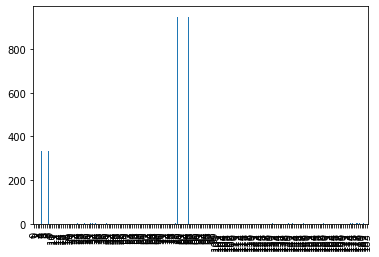

In [50]:
ngs_reads['module_9_distinct_seq'].plot(kind='bar')

<AxesSubplot:>

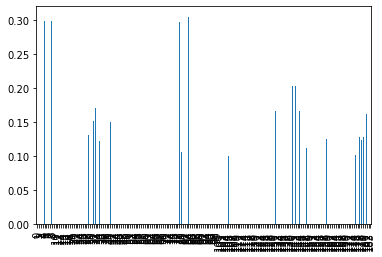

In [51]:
ngs_reads['module_9_mean_perc'].plot(kind='bar')

<AxesSubplot:>

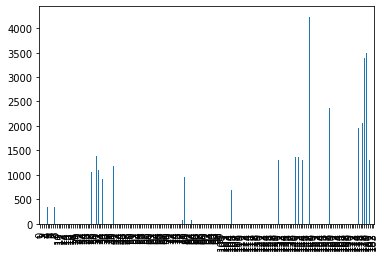

In [52]:
ngs_reads['module_9_count_sum'].plot(kind='bar')

In [53]:
ngs_reads.drop(columns='Overrepresented sequences', inplace=True) # drop original column after feature extraction

### Module 10 - Adapter Content
[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/10%20Adapter%20Content.html)
> The Kmer Content module will do a generic analysis of all of the Kmers in your library to find those which do not have even coverage through the length of your reads. This can find a number of different sources of bias in the library which can include the presence of read-through adapter sequences building up on the end of your sequences.  
You can however find that the presence of any overrepresented sequences in your library (such as adapter dimers) will cause the Kmer plot to be dominated by the Kmers these sequences contain, and that it's not always easy to see if there are other biases present in which you might be interested.  
One obvious class of sequences which you might want to analyse are adapter sequences. It is useful to know if your library contains a significant amount of adapter in order to be able to assess whether you need to adapter trim or not. Although the Kmer analysis can theoretically spot this kind of contamination it isn't always clear. This module therefore does a specific search for a set of separately defined Kmers and will give you a view of the total proportion of your library which contain these Kmers. A results trace will always be generated for all of the sequences present in the adapter config file so you can see the adapter content of your library, even if it's low.  
The plot itself shows a cumulative percentage count of the proportion of your library which has seen each of the adapter sequences at each position. Once a sequence has been seen in a read it is counted as being present right through to the end of the read so the percentages you see will only increase as the read length goes on. 

Adapter Content will be ignored for feature engineering.

In [54]:
ngs_reads.drop(columns='Adapter Content', inplace=True)